# YouTube Trending Video Dislike Prediction Model
### This model was created using a Trending YouTube Dataset from Kaggle
#### The dataset contains daily top trending videos from 2017- late 2018

###### I begin by importing the various libraries I will be using along with the datset file

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import seaborn as sns
from sklearn import preprocessing
from sklearn import svm

In [2]:
yt_data_us = r"C:\Users\mjeas\Desktop\CoderGirl\YT_Data\USvideos.csv"
yt_df = pd.read_csv(yt_data_us)

#### Now I am going to dop the columns that I am not interested in and clean up the rest of the data to a useable format. I also do some feature engineering to create a new date column

In [3]:
#Dropping the categories that I am not interested in
yt_clean = yt_df.drop(['thumbnail_link','description','tags','title', 'comments_disabled', 'ratings_disabled','video_id', 'channel_title'], axis=1)

#Pullout out all records that have deleted the posted trending video
yt_clean = yt_clean.drop(yt_clean[yt_clean.video_error_or_removed == True].index)

#Changing these categories to standardized date types
yt_clean['publish_time'] = pd.to_datetime(yt_clean.publish_time).dt.tz_localize(None)
yt_clean['trending_date'] = pd.to_datetime(yt_clean['trending_date'],format='%y.%d.%m')

yt_clean['category_id']= yt_clean['category_id'].astype(str)

#Adding in category names
yt_clean['category_id'] = yt_clean['category_id'].map({'1':'Film & Animation', '2':'Autos & Vehicles', '10': 'Music', '15': 'Pets & Animals', '17':'Sports', '18':'Short Movies', '19':'Travel & Events',
              '20': 'Gaming', '21':'Videoblogging', '22':'People & Blogs', '23':'Comedy', '24':'Entertainment', '25':'Howto & Sytle', '27':'Education',
              '28':'Science & Technology', '29':'Nonprofits & Activism', '30':'Movies', '31':'Anime/Animation', '32':'Action/Adventure', '33':'Classics',
              '34': 'Comedy', '35':'Documentary', '36': 'Drama', '37': 'Family', '38': 'Foreign', '39':'Horror', '40':'Sci-Fi/Fantasy', '42': 'Shorts',
               '43': 'Shows', '44': 'Trailers'})

#Now I want to add a new column that has the time it took a video to trend from publishing
yt_clean['time_til_trend']= yt_clean['trending_date']- yt_clean['publish_time']
yt_clean['time_til_trend']= yt_clean['time_til_trend'].dt.days

In [4]:
yt_clean.head()

,trending_date,category_id,publish_time,views,likes,dislikes,comment_count,video_error_or_removed,time_til_trend
0,2017-11-14,People & Blogs,2017-11-13 17:13:01,748374,57527,2966,15954,False,0
1,2017-11-14,Entertainment,2017-11-13 07:30:00,2418783,97185,6146,12703,False,0
2,2017-11-14,Comedy,2017-11-12 19:05:24,3191434,146033,5339,8181,False,1
3,2017-11-14,Entertainment,2017-11-13 11:00:04,343168,10172,666,2146,False,0
4,2017-11-14,Entertainment,2017-11-12 18:01:41,2095731,132235,1989,17518,False,1


#### With this correlation graph, we can see that there is a strong correlation between likes, dislikes, comment_count, and views. Since I want to predict dislikes, I will use likes, dislikes, comment_count, and views as my initial X variables.

<AxesSubplot:>

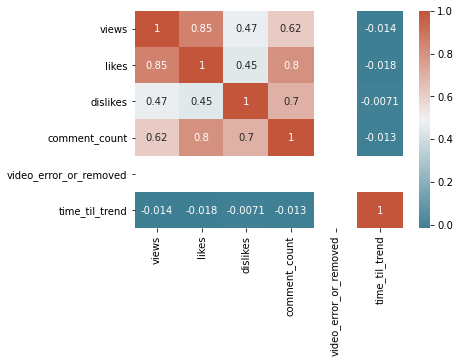

In [6]:
corr = yt_clean.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


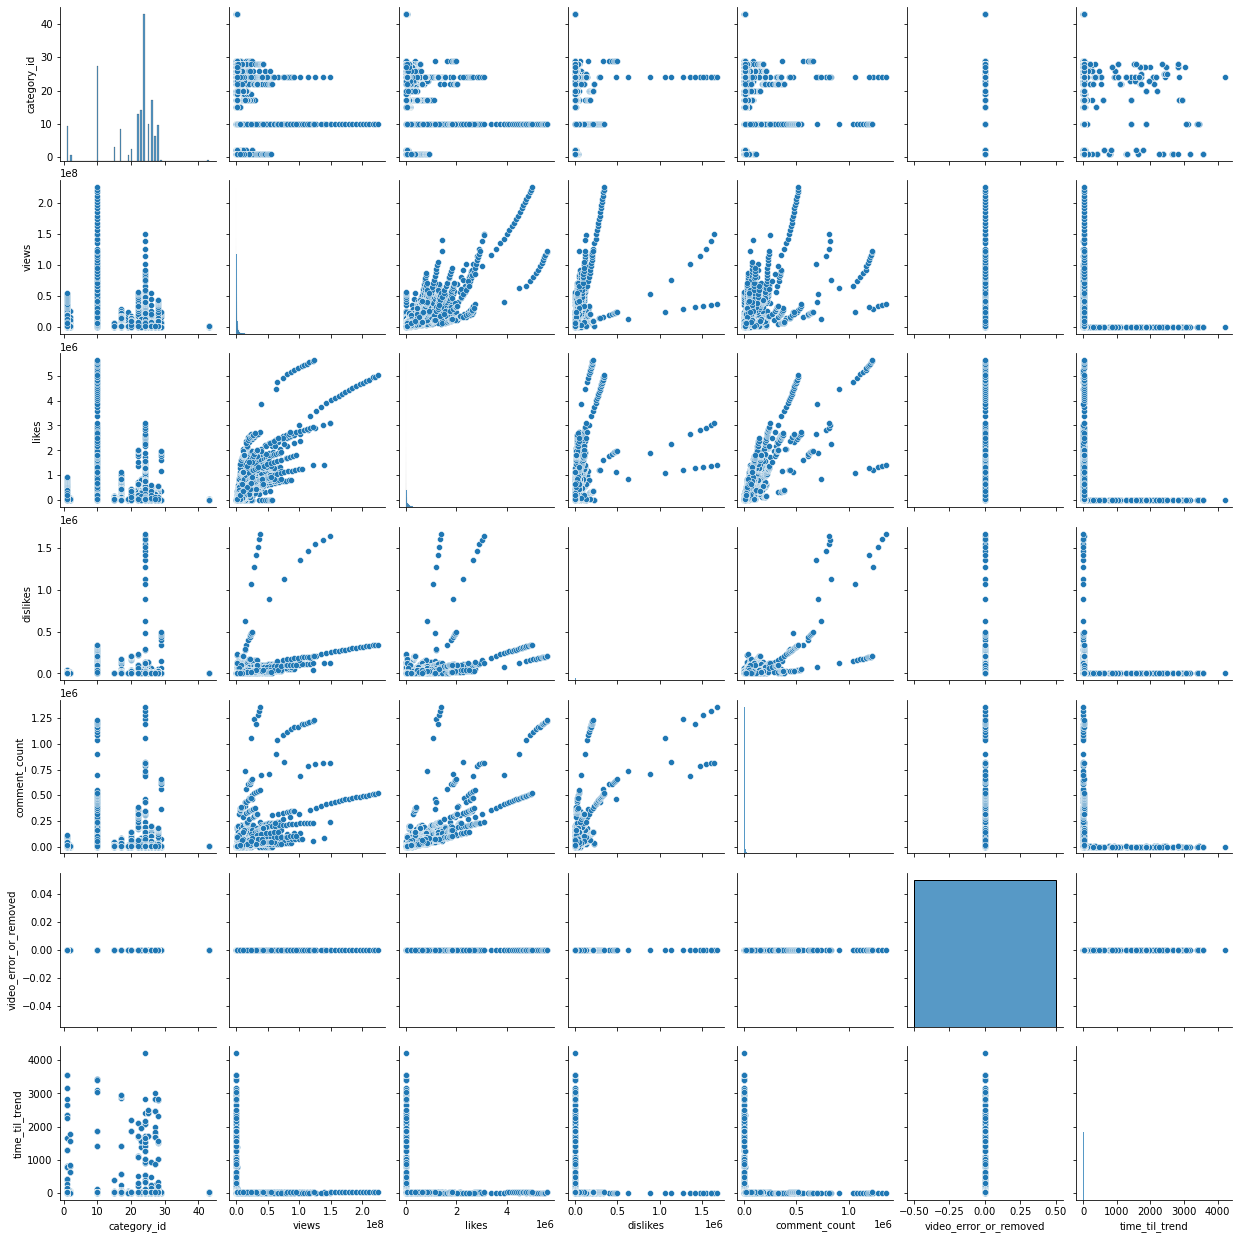

In [5]:
sns.pairplot(yt_clean)

#### Checking out the most liked categories

[Text(0, 0, 'People & Blogs'),
 Text(1, 0, 'Entertainment'),
 Text(2, 0, 'Comedy'),
 Text(3, 0, 'Science & Technology'),
 Text(4, 0, 'Film & Animation'),
 Text(5, 0, 'Howto & Sytle'),
 Text(6, 0, 'Sports'),
 Text(7, 0, 'Music'),
 Text(8, 0, 'Pets & Animals'),
 Text(9, 0, 'Education'),
 Text(10, 0, 'Autos & Vehicles'),
 Text(11, 0, 'Travel & Events'),
 Text(12, 0, 'Gaming'),
 Text(13, 0, 'Nonprofits & Activism'),
 Text(14, 0, 'Shows')]

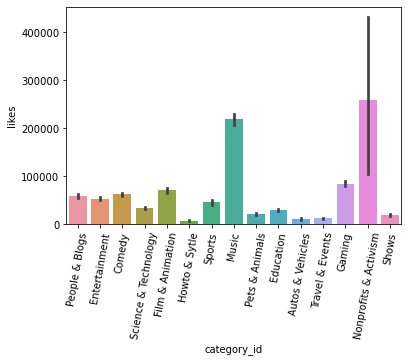

In [7]:
ax = sns.barplot(x="category_id", y="likes", data=yt_clean)
ax.set_xticklabels(ax.get_xticklabels(), rotation= 80)

#### Now I want to see what the most disliked categories are. It looks like videos in the Non-profit and Activism category are both some of the most liked and disliked videos out of all the categories.In the future, I would be interested in predicting dislikes on this category of videos. For now, I do not have enough samples of that data alone to create a good model.

[Text(0, 0, 'People & Blogs'),
 Text(1, 0, 'Entertainment'),
 Text(2, 0, 'Comedy'),
 Text(3, 0, 'Science & Technology'),
 Text(4, 0, 'Film & Animation'),
 Text(5, 0, 'Howto & Sytle'),
 Text(6, 0, 'Sports'),
 Text(7, 0, 'Music'),
 Text(8, 0, 'Pets & Animals'),
 Text(9, 0, 'Education'),
 Text(10, 0, 'Autos & Vehicles'),
 Text(11, 0, 'Travel & Events'),
 Text(12, 0, 'Gaming'),
 Text(13, 0, 'Nonprofits & Activism'),
 Text(14, 0, 'Shows')]

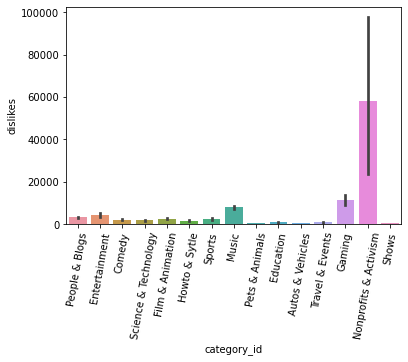

In [8]:
ax = sns.barplot(x="category_id", y="dislikes", data=yt_clean)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)

In [16]:
yt_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40926 entries, 0 to 40948
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trending_date           40926 non-null  datetime64[ns]
 1   category_id             36780 non-null  object        
 2   publish_time            40926 non-null  datetime64[ns]
 3   views                   40926 non-null  int64         
 4   likes                   40926 non-null  int64         
 5   dislikes                40926 non-null  int64         
 6   comment_count           40926 non-null  int64         
 7   video_error_or_removed  40926 non-null  bool          
 8   time_til_trend          40926 non-null  int64         
dtypes: bool(1), datetime64[ns](2), int64(5), object(1)
memory usage: 4.1+ MB


##### Next, I am taking a closer look at the X variables that I am interested in. 

<AxesSubplot:xlabel='time_til_trend'>

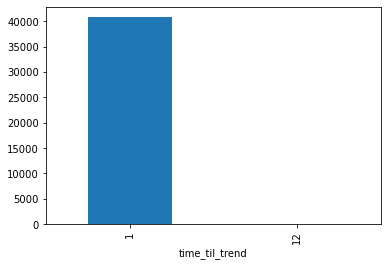

In [18]:
yt_clean["time_til_trend"] = pd.to_datetime(yt_clean["time_til_trend"])
yt_clean['time_til_trend'].groupby(yt_clean["time_til_trend"].dt.month).count().plot(kind="bar")

In [33]:
yt_clean["time_til_trend"] = yt_clean['time_til_trend'].astype('int64')

(array([3.8677e+04, 1.3720e+03, 4.1100e+02, 1.5500e+02, 1.0300e+02,
        3.8000e+01, 5.8000e+01, 2.5000e+01, 2.0000e+01, 2.4000e+01,
        8.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00,
        4.0000e+00, 5.0000e+00, 6.0000e+00, 4.0000e+00, 6.0000e+00]),
 array([      0.  ,  280691.35,  561382.7 ,  842074.05, 1122765.4 ,
        1403456.75, 1684148.1 , 1964839.45, 2245530.8 , 2526222.15,
        2806913.5 , 3087604.85, 3368296.2 , 3648987.55, 3929678.9 ,
        4210370.25, 4491061.6 , 4771752.95, 5052444.3 , 5333135.65,
        5613827.  ]),
 <BarContainer object of 20 artists>)

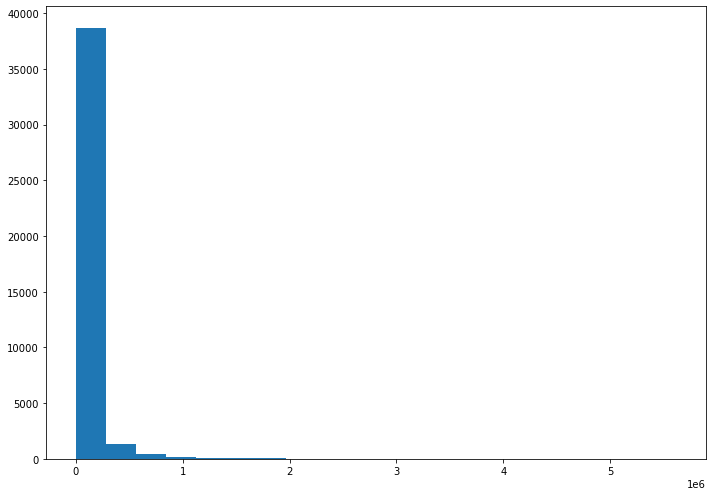

In [20]:
#yt_clean.hist(column="likes")
fig, axs = plt.subplots(1, 1, 
                        figsize =(10, 7),  
                        tight_layout = True)
axs.hist(yt_clean['likes'], bins = 20) 

(array([4.0283e+04, 3.2700e+02, 1.6700e+02, 4.6000e+01, 1.8000e+01,
        2.1000e+01, 1.4000e+01, 1.4000e+01, 4.0000e+00, 4.0000e+00,
        4.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        3.0000e+00, 2.0000e+00, 8.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([      0.,   68079.,  136158.,  204237.,  272316.,  340395.,
         408474.,  476553.,  544632.,  612711.,  680790.,  748869.,
         816948.,  885027.,  953106., 1021185., 1089264., 1157343.,
        1225422., 1293501., 1361580.]),
 <BarContainer object of 20 artists>)

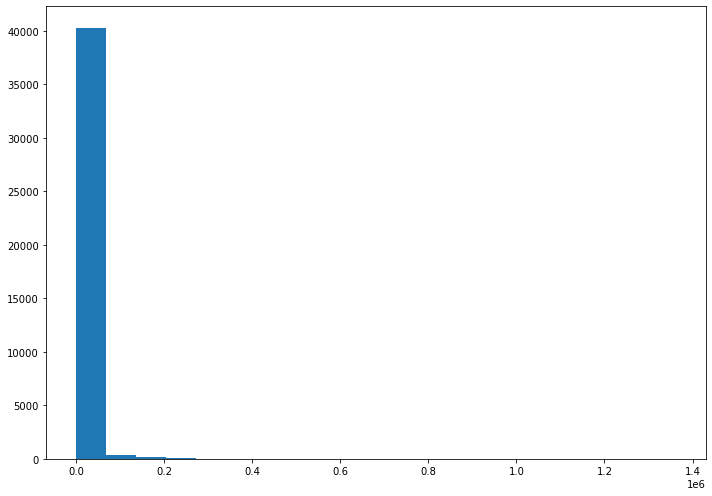

In [23]:
#yt_clean.hist(column="comment_count")
fig, axs = plt.subplots(1, 1, 
                        figsize =(10, 7),  
                        tight_layout = True)
axs.hist(yt_clean['comment_count'], bins = 20)

(array([3.9277e+04, 1.0660e+03, 2.2400e+02, 1.4400e+02, 8.1000e+01,
        4.6000e+01, 2.1000e+01, 1.8000e+01, 1.0000e+01, 7.0000e+00,
        9.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([5.49000000e+02, 1.12611177e+07, 2.25216864e+07, 3.37822551e+07,
        4.50428238e+07, 5.63033925e+07, 6.75639612e+07, 7.88245299e+07,
        9.00850986e+07, 1.01345667e+08, 1.12606236e+08, 1.23866805e+08,
        1.35127373e+08, 1.46387942e+08, 1.57648511e+08, 1.68909080e+08,
        1.80169648e+08, 1.91430217e+08, 2.02690786e+08, 2.13951354e+08,
        2.25211923e+08]),
 <BarContainer object of 20 artists>)

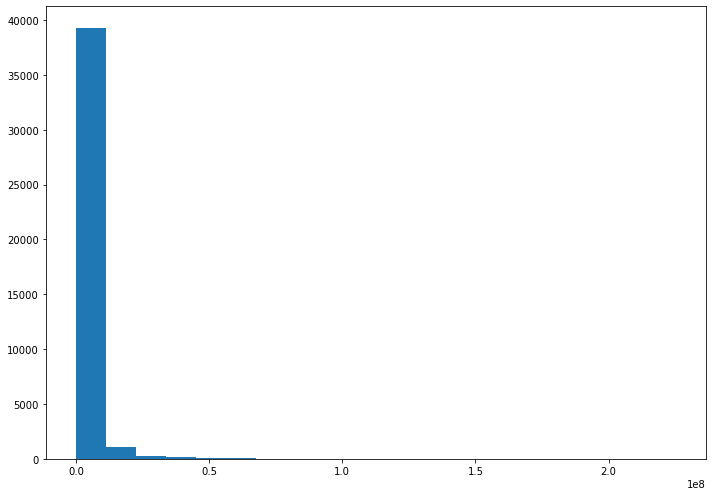

In [24]:
#yt_clean.hist(column="views")
fig, axs = plt.subplots(1, 1, 
                        figsize =(10, 7),  
                        tight_layout = True)
axs.hist(yt_clean['views'], bins = 20)

#### We notice from these graphs and histograms that the majority of the data is positively skewed even with a large bin size (20). Now I will examine relationships between the X variables and Y.

<AxesSubplot:xlabel='comment_count', ylabel='dislikes'>

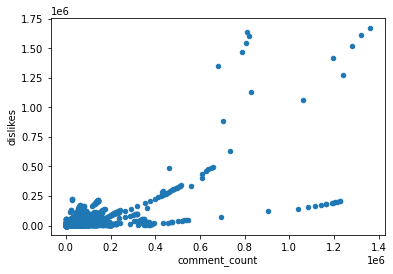

In [26]:
yt_clean.plot(kind='scatter', x='comment_count', y='dislikes')

<AxesSubplot:xlabel='views', ylabel='dislikes'>

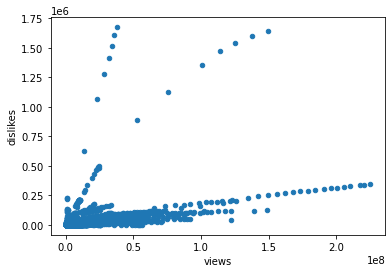

In [27]:
yt_clean.plot(kind='scatter', x='views', y='dislikes')

#### Now I will drop the last few columns that I don't need anymore.

In [4]:
#Doing a second drop of category_id now that I am done examining it.
drop_cols = ['category_id','video_error_or_removed','publish_time', 'trending_date'] 
yt_clean = yt_clean.drop(drop_cols, axis=1)


#### Now that my data is cleaned, I can begin the normalization process on my variables.

In [5]:
# Using sklearn to normalize the data
from sklearn.preprocessing import StandardScaler
cols_to_norm = ['views','likes', 'dislikes', 'comment_count', 'time_til_trend']
yt_clean[cols_to_norm] = StandardScaler().fit_transform(yt_clean[cols_to_norm])

#Pull out our y variable from the dataset
Y = yt_clean['dislikes']

drop_y = ['dislikes']
yt_clean= yt_clean.drop(drop_y, axis =1)

In [6]:
yt_clean.head()

,views,likes,comment_count,time_til_trend
0,-0.218070,-0.073182,0.200423,-0.108282
1,0.007789,0.100044,0.113592,-0.108282
2,0.112260,0.313412,-0.007188,-0.101435
3,-0.272858,-0.280028,-0.168378,-0.108282
4,-0.035892,0.253143,0.242197,-0.101435


#### Splitting out my training and testing data

In [8]:
#Train test split
from sklearn.model_selection import train_test_split
#X= yt_clean.values.reshape(-1,1)
X= yt_clean.to_numpy
Y= Y.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(yt_clean, Y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(32740, 4) (32740, 1)
(8186, 4) (8186, 1)


#### The first SVR model I am running utilizes the linear kernel.

In [9]:
#SVR model with views, likes, comment_count, and time_til_trend as parameters
from sklearn.svm import SVR

svr_lin = SVR(kernel='linear')
svr_lin.fit(X_train,y_train.ravel())

SVR(kernel='linear')

In [10]:
#Prediction
y_lin= svr_lin.predict(X_test)
y_lin.shape

(8186,)

In [11]:
#Model Performance
from sklearn.metrics import r2_score,mean_squared_error

mse= mean_squared_error(y_test, y_lin)
rmse= np.sqrt(mse)
rmse

0.7818879163964537

In [12]:
svr_lin.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel())

0.2909709939183338

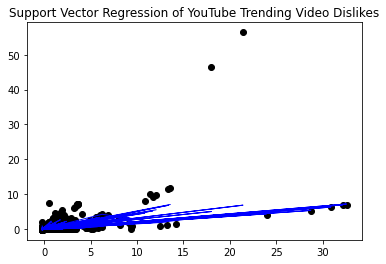

In [13]:
#Plot model performance (likes)
plt.title("Support Vector Regression of YouTube Trending Video Dislikes")
plt.scatter(X_test.iloc[:,2].values, y_test,  color='black')
plt.plot(X_test.iloc[:,2].values, y_lin, color='blue', linewidth=1)

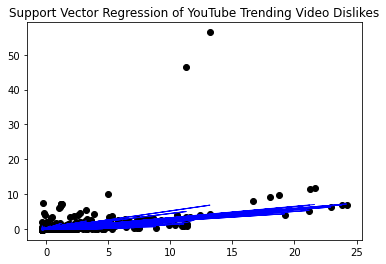

In [14]:
plt.title("Support Vector Regression of YouTube Trending Video Dislikes") #views
plt.scatter(X_test.iloc[:,1].values, y_test,  color='black')
plt.plot(X_test.iloc[:,1].values, y_lin, color='blue', linewidth=1)

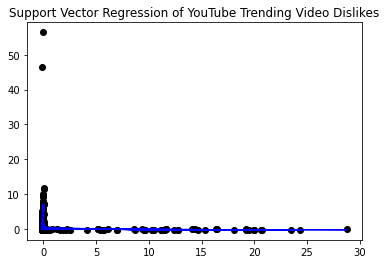

In [15]:
plt.title("Support Vector Regression of YouTube Trending Video Dislikes") #commentcount
plt.scatter(X_test.iloc[:,3].values, y_test,  color='black')
plt.plot(X_test.iloc[:,3].values, y_lin, color='blue', linewidth=1)

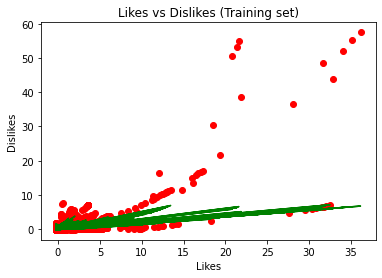

In [16]:
#Visualization of the training set results
plt.scatter(X_train.iloc[:,2].values, y_train, color = 'red')
plt.plot(X_train.iloc[:,2].values, svr_lin.predict(X_train), color = 'green')
plt.title('Likes vs Dislikes (Training set)')
plt.xlabel('Likes')
plt.ylabel('Dislikes')
plt.show()

#### Now I am running SVR with kernel= rbf

In [17]:
#Now going to try kernel= rbf
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train,y_train.ravel())

SVR()

In [18]:
y_rbf= svr_rbf.predict(X_test)
y_rbf

array([-0.02878737,  0.00585491, -0.02803805, ..., -0.02915454,
       -0.02580251, -0.02353121])

In [19]:
mse= mean_squared_error(y_test, y_rbf)
rmse= np.sqrt(mse)
rmse

0.8184084371023482

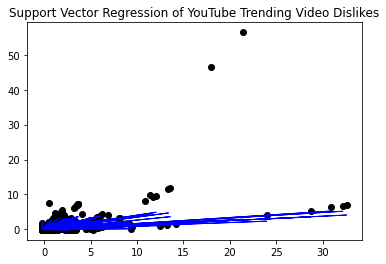

In [20]:
plt.title("Support Vector Regression of YouTube Trending Video Dislikes")
plt.scatter(X_test.iloc[:,2].values, y_test,  color='black')
plt.plot(X_test.iloc[:,2].values, y_rbf, color='blue', linewidth=1)

#### SVR kernel = poly

In [21]:
svr_poly = SVR(kernel='poly')
svr_poly.fit(X_train,y_train.ravel())

SVR(kernel='poly')

In [22]:
y_poly= svr_poly.predict(X_test)
y_poly

array([-0.02952301, -0.02383722, -0.02457199, ..., -0.02942051,
       -0.02846226, -0.02829816])

In [23]:
mse= mean_squared_error(y_test, y_poly)
rmse= np.sqrt(mse)
rmse

0.39990397858487864

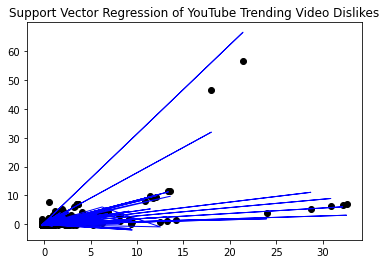

In [25]:
plt.title("Support Vector Regression of YouTube Trending Video Dislikes")
plt.scatter(X_test.iloc[:,2].values, y_test,  color='black')
plt.plot(X_test.iloc[:,2].values, y_poly, color='blue', linewidth=1)

#### In using Support Vector Regression to predict YouTube dislikes, I have found that using a polynomial kerneal produces the best results with an rmse of 0.4. In future, I would like to try re-running all of the models and fine tuning other hyperparameters to see if I can achrive an improved rmse score.